In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from implementations import *
DATA_TRAIN_PATH = 'data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
DATA_TEST_PATH = 'data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [3]:
def map_label_01(y):
    y_logistic = []
    for elem in y:
        if elem == -1:
            y_logistic.append(0)
        else:
            y_logistic.append(1)
            
    return np.asarray(y_logistic)

In [4]:
def divide_train_test(y, tx, k_indices, k):
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    test_tx = tx[k_indices[k]]
    test_y = y[k_indices[k]]
    train_tx = tx[tr_indice]
    train_y = y[tr_indice]
    
    return test_tx, test_y, train_tx, train_y

In [5]:
def cross_validation_least_squares_GD(y, tx, initial_w, max_iters, gammas, k_fold, seed):
    """Do cross-validation to find the best gamma to use with least_squares_GD"""
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    mse_tr = []
    mse_te = []
    
    weights = initial_w
    
    for gamma in gammas:
        tr_tmp = []
        te_tmp = []
        for k in range(k_fold):
            # divide the data into training set and testing set depending on k
            test_tx, test_y, train_tx, train_y = divide_train_test(y, tx, k_indices, k)
            
            #Train the set and computes the losses
            weights, loss_tr = least_squares_GD(train_y, train_tx, initial_w, max_iters, gamma)
            loss_te = compute_loss(mse, test_y, test_tx, weights)
            
            tr_tmp.append(loss_tr)
            te_tmp.append(loss_te)
        mse_tr.append(np.mean(tr_tmp))
        mse_te.append(np.mean(te_tmp))

    gamma = gammas[np.argmin(mse_te)]
    weights_final, loss = least_squares_GD(y, tx, initial_w, max_iters, gamma)
        
    return mse_tr, mse_te, gamma, weights_final, loss

In [6]:
def cross_validation_logistic_regression(y, tx, initial_w, max_iters, gammas, k_fold, seed):
    """Do cross-validation to find the best gamma to use with logistic regression"""
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    loss_sigmoid_tr = []
    loss_sigmoid_te = []
    
    weights = initial_w
    
    for gamma in gammas:
        tr_tmp = []
        te_tmp = []
        for k in range(k_fold):
            # divide the data into training set and testing set depending on k
            test_tx, test_y, train_tx, train_y = divide_train_test(y, tx, k_indices, k)
            
            #Train the set and computes the losses
            weights, loss_tr = logistic_regression(train_y, train_tx, initial_w, max_iters, gamma)
            loss_te = compute_loss_sigmoid(test_y, test_tx, weights)
            
            tr_tmp.append(loss_tr)
            te_tmp.append(loss_te)
        loss_sigmoid_tr.append(np.mean(tr_tmp))
        loss_sigmoid_te.append(np.mean(te_tmp))
        
    gamma = gammas[np.argmin(loss_sigmoid_te)]
    weights_final, loss_sigmoid = logistic_regression(y, tx, initial_w, max_iters, gamma)
        
    return loss_sigmoid_tr, loss_sigmoid_te, gamma, weights_final, loss_sigmoid

In [7]:
#least_squares_GD cross-validation
max_iters = 200
k_fold = 5
seed = 42

tX_stdrzed, mean, std = standardize(tX)

initial_w = np.array([0.4 for i in range(tX_stdrzed.shape[1])])

gammas_lsgd = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])
mse_tr_least_squares_GD, mse_te_least_squares_GD, gamma, weights, loss = \
    cross_validation_least_squares_GD(y, tX_stdrzed, initial_w, max_iters, gammas_lsgd, k_fold, seed)

print(mse_tr_least_squares_GD)
print(mse_te_least_squares_GD)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd = (tX_test-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd)
OUTPUT_PATH = 'data/output_least_squares_GD.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.697 on AICrowd initial_w = np.array([0.4 for i in range(tX_stdrzed.shape[1])]) 
#0.693 on AICrowd initial_w = np.array([0.0 for i in range(tX_stdrzed.shape[1])]) even if loss smaller

[0.45823980409406173, 0.43418457916825776, 0.42126372236647364, 0.4135839312475572, 0.40868479367772537, 0.4053131436732774, 0.4028153087172398, 0.4008444264267169, 115117778208918.6]
[0.45807734577542963, 0.4340343340367541, 0.421138145745856, 0.41348544027058753, 0.4086077815003658, 0.40525115352914165, 0.40276328390919847, 0.4007989307887804, 134769438904640.6]
0.08
[ 0.20627743 -0.29827408 -0.13780875  0.11333712 -0.02654456  0.29023748
 -0.0323207   0.05010637 -0.01812791 -0.15189726  0.04598917  0.05925195
 -0.02573167  0.13925984  0.0542319   0.05412405 -0.07285198  0.05423237
  0.05448766  0.01635418  0.05465347 -0.25068937  0.04912037  0.02186124
  0.02747376  0.02749889 -0.11803008 -0.02579634 -0.02597091 -0.10958051]
0.4008474070492306


In [8]:
#logistic_regression cross-validation
max_iters = 1000
k_fold = 5
seed = 42

tX_stdrzed, mean, std = standardize(tX)
y_logistic = map_label_01(y)
        
initial_w = np.array([0.5 for i in range(tX_stdrzed.shape[1])])
gammas_logistic = np.array([0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005])

losses_tr_logistic_regression, losses_te_logistic_regression, gamma, weights, loss = \
    cross_validation_logistic_regression(y_logistic, tX_stdrzed, initial_w, max_iters, gammas_logistic, k_fold, seed)

print(losses_tr_logistic_regression)
print(losses_te_logistic_regression)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd = (tX_test-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd)
OUTPUT_PATH = 'data/output_logistic_regression.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.739 on AICrowd

[119234.72136937102, 114701.75874088134, 110707.52958311737, 107219.91896314784, 151683.24341274827]
[29813.655190211284, 28678.300918293662, 27678.107134920818, 26804.857253817918, 65299.053048292524]
1e-06
[  0.36531303 -13.23580889  -1.36978412   0.59362265   0.01829388
   1.0485483   -0.11879144   0.8850403   -0.58606976   2.92957168
   0.06444547   1.1266104    0.04727472   9.96840227   0.49415231
   0.45444178  -0.83475413   0.49056577   0.55668614   2.76278716
   0.53217031  -0.85230769   0.42357264  -0.1192031    0.11001104
   0.12393645  -0.92277756  -0.03229972  -0.05384817  -5.18779562]
132134.77621962118


In [9]:
#least_squares_GD cross-validation with cleaned data
max_iters = 200
k_fold = 5
seed = 42

tX_stdrzed_cleaned, mean, std = standardize(remove_wrong_columns(tX))

initial_w = np.array([0.4 for i in range(tX_stdrzed_cleaned.shape[1])]) 
gammas_lsgd_clean = np.array([0.01, 0.05, 0.1, 0.11, 0.12, 0.128])

mse_tr_least_squares_GD_clean, mse_te_least_squares_GD_clean, gamma, weights, loss = \
    cross_validation_least_squares_GD(y, tX_stdrzed_cleaned, initial_w, max_iters, gammas_lsgd_clean, k_fold, seed)

print(mse_tr_least_squares_GD_clean)
print(mse_te_least_squares_GD_clean)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd_cleaned = (remove_wrong_columns(tX_test)-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd_cleaned)
OUTPUT_PATH = 'data/output_least_squares_GD_clean.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.72 on AICrowd

[0.4829444274069787, 0.3785810578920398, 0.37585500287088003, 0.37569930267400325, 0.37556759611875135, 0.6061135886916136]
[0.4823999202585222, 0.37856564679284066, 0.37588735835461606, 0.37573361444383624, 0.37560345237880965, 0.6036864256436408]
0.12
[-0.67353872 -0.01935749  0.08089317  0.10270136 -0.09230546  0.14814314
  0.05376114  0.10372283  0.42233461  0.06302186  0.06079259  0.012026
  0.0630258   0.06600923  0.06210411  0.06446594 -0.03588135  0.07445922
 -0.15745303]
0.37557229648318674


In [10]:
#logistic_regression cross-validation with cleaned data
max_iters = 1000
k_fold = 5
seed = 42

tX_stdrzed_cleaned, mean, std = standardize(remove_wrong_columns(tX))
y_logistic = map_label_01(y)
        
initial_w = np.array([0.5 for i in range(tX_stdrzed_cleaned.shape[1])])
gammas_logistic_clean = np.array([0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005])

losses_tr_logistic_regression_clean, losses_te_logistic_regression_clean, gamma, weights, loss = \
    cross_validation_logistic_regression(y_logistic, tX_stdrzed_cleaned,\
                                         initial_w, max_iters, gammas_logistic_clean, k_fold, seed)

print(losses_tr_logistic_regression_clean)
print(losses_te_logistic_regression_clean)
print(gamma)
print(weights)
print(loss)

tX_test_stdrzd_cleaned = (remove_wrong_columns(tX_test)-mean)/std

y_pred = predict_labels(weights, tX_test_stdrzd_cleaned)
OUTPUT_PATH = 'data/output_logistic_regression_clean.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

#0.727 on AICrowd

/Users/julie/Documents/Repos/Machine-learning/project1/implementations.py:76: RuntimeWarning: divide by zero encountered in log
  return -np.sum(y.T @ np.log(sigm_tx_w) + (1 - y).T @ np.log(1 - sigm_tx_w))
/Users/julie/Documents/Repos/Machine-learning/project1/implementations.py:140: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(loss - previous_loss) < THRESHOLD:


[115048.57307658333, 110085.49502091494, 109742.34911606026, 109637.62706043373, 140555.66091008447]
[28748.10879878667, 27519.744229116906, 27437.749943622748, 27412.342800407292, 35879.948855128336]
1e-06
[-2.08973515 -0.24823485 -0.07147538  2.55401869 -0.3150045   0.90824787
 -1.38819557  3.34075216  0.95287676 -0.50091827 -0.67883422 -0.13846141
 -0.49541696 -0.27860939  0.41693432 -0.42950819 -0.08900212  0.3617896
 -0.93931162]
136445.60557867214


# Graphs

In [11]:
def make_plots_gammas(te_losses, gammas, save_name, title):
    plt.semilogx(gammas, te_losses, marker=".", color='b', label='cross-validation test error')
    plt.xlabel("gamma")
    plt.ylabel("error")
    plt.title(title)
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig(save_name)

In [12]:
def make_plots_raw_vs_clean(raw_loss, clean_loss, gammas_raw, gammas_clean, save_name, title):
    plt.semilogx(gammas_raw, raw_loss, marker=".", color='b', label='raw data')
    plt.semilogx(gammas_clean, clean_loss, marker=".", color='r', label='clean data')
    plt.xlabel("gamma")
    plt.ylabel("error")
    plt.title(title)
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig(save_name)

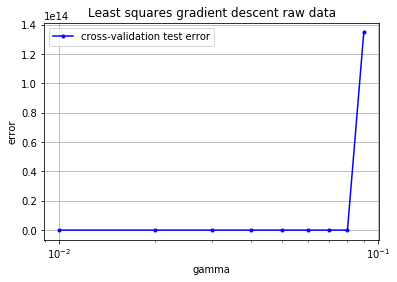

In [13]:
#Least squares
make_plots_gammas(mse_te_least_squares_GD, gammas_lsgd, \
                  "raw_data_least_squares_GD", "Least squares gradient descent raw data")

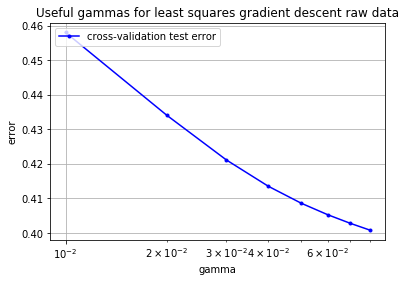

In [14]:
#Least squares without disturbing gamma
make_plots_gammas(mse_te_least_squares_GD[:-1], gammas_lsgd[:-1], \
                  "raw_data_least_squares_GD_useful", "Useful gammas for least squares gradient descent raw data")

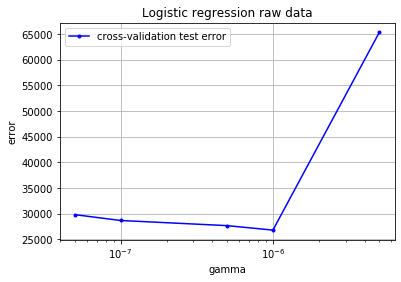

In [15]:
#Logistic regression
make_plots_gammas(losses_te_logistic_regression, gammas_logistic, \
                  "raw_data_logistic_regression", "Logistic regression raw data")

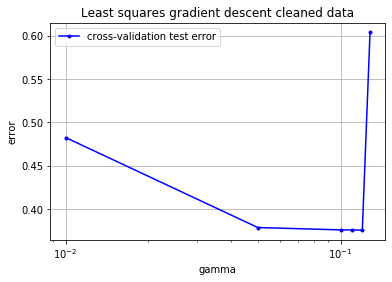

In [16]:
#Least squares with cleaned data
make_plots_gammas(mse_te_least_squares_GD_clean, gammas_lsgd_clean, \
                  "clean_data_least_squares_GD", "Least squares gradient descent cleaned data")

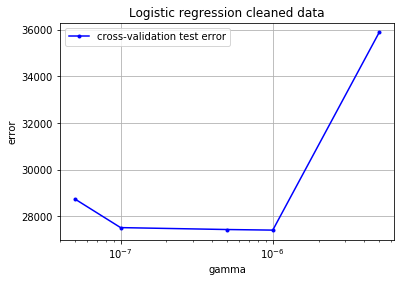

In [17]:
#Logistic regression with cleaned data
make_plots_gammas(losses_te_logistic_regression_clean, gammas_logistic_clean, \
                  "clean_data_logistic_regression", "Logistic regression cleaned data")

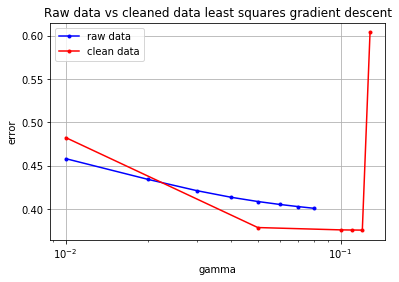

In [18]:
#Clean vs raw least_squares_GD
make_plots_raw_vs_clean(mse_te_least_squares_GD[:-1], mse_te_least_squares_GD_clean, \
                        gammas_lsgd[:-1], gammas_lsgd_clean,\
                  "raw_vs_clean_lsgd", "Raw data vs cleaned data least squares gradient descent")

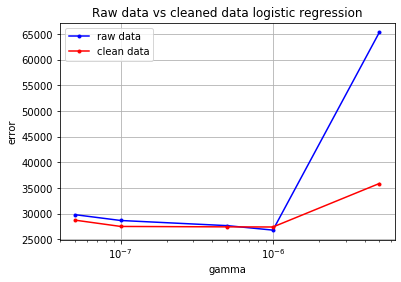

In [19]:
#Clean vs raw logistic regression
make_plots_raw_vs_clean(losses_te_logistic_regression, losses_te_logistic_regression_clean, \
                        gammas_logistic, gammas_logistic_clean,\
                  "raw_vs_clean_log_reg", "Raw data vs cleaned data logistic regression")